In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import math
from collections import OrderedDict
from tqdm import tqdm

In [2]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial import cKDTree

In [3]:
import sys
sys.path.insert(0, '../models/')
from model_v1 import *
sys.path.pop(0)
from simplebool_data_gen import *
from simple_heatmap import *

In [4]:
%load_ext autoreload
%autoreload 2

## Code Testing

In [5]:
emb_dims = [2,4]

In [6]:
model = WangNet(emb_dims=emb_dims, no_of_cont=2, lin_layer_sizes=[8, 16, 8, 4], \
                output_size=1, hidden_drop_p=0, batch_flag=False).cuda()
save_path = "../saved_model_params/simple_model_state_dict.pt"
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [7]:
get_heatmap(model, 99999, 0.1, 1, 1e-3, "Adam")

AssertionError: Train data statistics have not been cached yet.

## Data Gen

In [5]:
# Normalized training data from get_train_data()
X_train, y_train = get_train_data([5000, 5000])

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

train_data = []
for i in range(len(X_train)):
    train_data.append([X_train[i], y_train[i]])

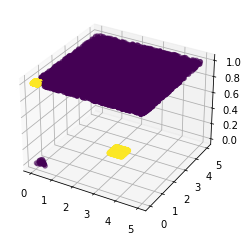

In [6]:
# Plotting the training data, unstandardized
X_train_orig = unstandardize_data(X_train, cache["X_train_mean"], cache["X_train_std"])

ax = plt.axes(projection='3d')
ax.scatter3D(X_train_orig[:, 0], X_train_orig[:, 1], y_train, c=X_train[:,2])
# plt.xlim(0,1)
# plt.ylim(0,1)
# Purple is boolean = 0, yellow is boolean = 1

In [9]:
X_testA, X_testA_orig, y_testA = get_test_splitA(1000)
X_testA = torch.tensor(X_testA).float()
y_testA = torch.tensor(y_testA).view(-1, 1).float()

In [10]:
# Checks if all the values of the two tensors are close together, using torch.isclose()

def checkTensorClose(tensor1, tensor2, atol):
    val_close = torch.sum(torch.isclose(tensor1, tensor2, atol=atol))
    bool_val = torch.sum(val_close) == torch.numel(tensor1)
    return bool_val.item()

In [11]:
# This allows you to look into trainloader and the data returned.

trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=64)
i1, l1 = next(iter(trainloader))
print(torch.max(X_train))
print(torch.min(X_train))
print(torch.max(y_train))
print(torch.min(y_train))

tensor(1.2879)
tensor(-1.2810)
tensor(1.)
tensor(0.)


## Model

In [12]:
def get_num_correct(labels, preds):
    preds = get_pred_class(preds)
    return (labels == preds).float().sum()

In [13]:
def get_pred_class(preds):
    return (preds > 0).float()

In [14]:
emb_dims = [2,4]

# Always keep batch size in powers of 2, trainloader works faster this way.
batch_size = 256
trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
num_batches = math.ceil(1.0 * len(train_data) / batch_size)
lr=1e-3

In [88]:
torch.cuda.get_device_name(0)

'GeForce RTX 2080 Ti'

In [89]:
model = WangNet(emb_dims=emb_dims, no_of_cont=2, lin_layer_sizes=[8, 16, 8, 4], \
                output_size=1, hidden_drop_p=0, batch_flag=False).cuda()

n_epochs = 100
loss_values = []
acc_values = []
norm_values = []
test_splitA_values = []
test_splitB_values = []

pos_weight = torch.FloatTensor([np.count_nonzero(y_train==0), np.count_nonzero(y_train==1)])/len(y_train)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

# Let's look at how the model does on test split A, during training.
X_testA, X_testA_orig, y_testA = get_test_splitA(1000)
X_testA = torch.tensor(X_testA).float().cuda()
y_testA = torch.tensor(y_testA).view(-1, 1).float().cuda()

# Let's look at how the model does on test split B, during training.
X_testB, X_testB_orig, y_testB = get_test_splitB([500,500])
X_testB = torch.tensor(X_testB).float().cuda()
y_testB = torch.tensor(y_testB).view(-1, 1).float().cuda()

# Let's plot test split D, to see how the model guesses during training phase.
X_testD, X_testD_orig, y_testD = get_test_splitD(1000)
X_testD = torch.tensor(X_testD).float().cuda()
y_testD = torch.tensor(y_testD).view(-1, 1).float().cuda()

t = tqdm(range(1, n_epochs+1), miniters=100)
steps = 0

for epoch in t:
    total_loss = 0
    correct = 0
    
    with torch.no_grad():
        predsA = model(X_testA[:,:2].float(), X_testA[:,2].long())
        testA_acc = get_num_correct(y_testA, predsA) / len(X_testA)
        test_splitA_values.append(testA_acc)
                
        predsB = model(X_testB[:,:2].float(), X_testB[:,2].long())
        testB_acc = get_num_correct(y_testB, predsB) / len(X_testB)
        test_splitB_values.append(testB_acc)
        
        predsD = model(X_testD[:,:2].float(), X_testD[:,2].long())
        testD_acc = get_num_correct(y_testD, predsD) / len(X_testD)
#         save_plt(X_testD_orig, y_testD, predsD, epoch, testD_acc)
                
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        cont_x = inputs[:,:2].float().cuda()
        cat_x = inputs[:,2].long().cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        
        preds = model(cont_x, cat_x)

        loss = criterion(preds, labels)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        # scheduler.step()
        correct += get_num_correct(labels, preds)
        
    for name, param in model.named_parameters():
        grad_norm_sum = 0
        if param.requires_grad and param.grad is not None:
            grad = param.grad.view(-1)
            grad_norm_sum += torch.norm(grad).item()
            
    norm_values.append(grad_norm_sum)

    acc = correct/len(train_data)
    t.set_description(f"-----Epoch: {epoch}/{n_epochs}, Loss: {total_loss/num_batches}, Accuracy: {acc}-----")
    loss_values.append(total_loss/num_batches)
    acc_values.append(acc)

-----Epoch: 100/100, Loss: 0.011311642621876672, Accuracy: 0.9955999851226807-----: 100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


Text(0, 0.5, 'Training loss')

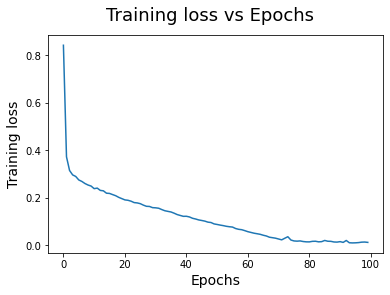

In [90]:
plt.plot(np.array(np.arange(0, n_epochs)), loss_values)
plt.suptitle('Training loss vs Epochs', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Training loss', fontsize=14)

Text(0, 0.5, 'Training accuracy')

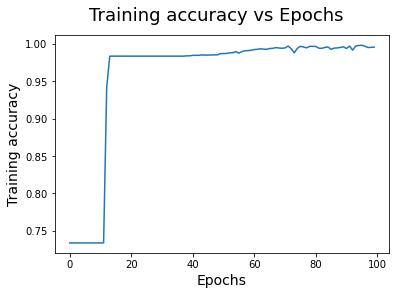

In [91]:
plt.plot(np.array(np.arange(0, n_epochs)), acc_values)
plt.suptitle('Training accuracy vs Epochs', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Training accuracy', fontsize=14)

Text(0, 0.5, 'Sum of gradient norms')

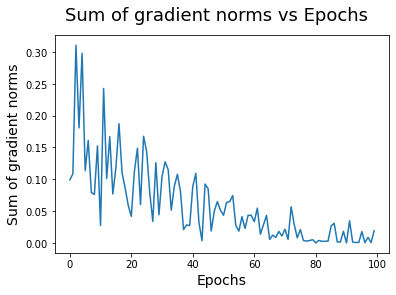

In [92]:
plt.plot(np.array(np.arange(0, n_epochs)), norm_values)
plt.suptitle('Sum of gradient norms vs Epochs', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Sum of gradient norms', fontsize=14)

Text(0, 0.5, 'Accuracy')

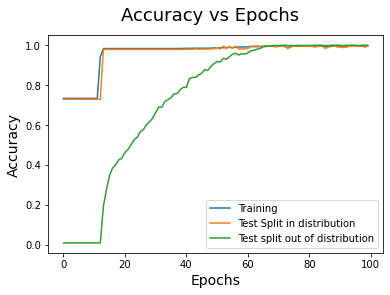

In [93]:
plt.plot(np.array(np.arange(0, n_epochs)), acc_values, label="Training")
plt.plot(np.array(np.arange(0, n_epochs)), test_splitB_values, label="Test Split in distribution")
plt.plot(np.array(np.arange(0, n_epochs)), test_splitA_values, label="Test split out of distribution")
plt.legend()
plt.suptitle('Accuracy vs Epochs', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

Total Accuracy on test split A: 0.996


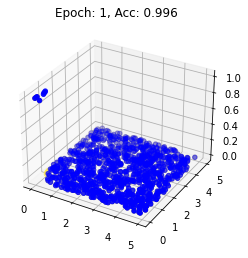

<Figure size 432x288 with 0 Axes>

In [63]:
#### Testing Split A
X_testA, X_testA_orig, y_testA = get_test_splitA(1000)

X_test_tnsr = torch.tensor(X_testA).cuda().float()
y_test_tnsr = torch.tensor(y_testA).view(-1, 1).cuda().float()

with torch.no_grad():
    predsA = model(X_test_tnsr[:,:2].float(), X_test_tnsr[:,2].long())
    total_acc = get_num_correct(y_test_tnsr, predsA) / len(X_test_tnsr)
    total_acc = np.round(total_acc, 6)
print(f"Total Accuracy on test split A: {total_acc}")
    
# Comment this line out to see the non-classification predictions.
probsA = tensor_to_numpy(get_prob_zero(predsA))
predsA = get_pred_class(predsA)
predsA = tensor_to_numpy(predsA)

# X_testA_orig = unstandardize_data(X_testA, cache["X_testA_mean"], cache["X_testA_std"])
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_testA_orig[:, 0], X_testA_orig[:, 1], y_testA, c="#F9E755")
ax.scatter3D(X_testA_orig[:, 0], X_testA_orig[:, 1], predsA, c='blue')
ax.set_title(f"Epoch: {1}, Acc: {total_acc}")
plt.show()
plt.clf()

Total Accuracy on test split B: 0.985


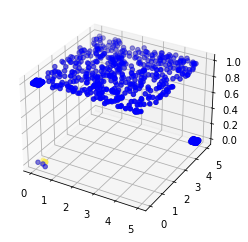

In [64]:
# Testing Split B
X_testB, X_testB_orig, y_testB = get_test_splitB([500,500])

X_test_tnsr = torch.tensor(X_testB).cuda().float()
y_test_tnsr = torch.tensor(y_testB).view(-1, 1).cuda().float()

with torch.no_grad():
    predsB = model(X_test_tnsr[:,:2].float(), X_test_tnsr[:,2].long())
    total_acc = get_num_correct(y_test_tnsr, predsB) / len(X_test_tnsr)
print(f"Total Accuracy on test split B: {total_acc}")

# # Comment this line out to see the non-classification predictions.
probsB = tensor_to_numpy(get_prob_zero(predsB))
predsB = get_pred_class(predsB)
predsB = tensor_to_numpy(predsB)

# B_indices_wrong = (((predsB != y_testB) == True).nonzero(as_tuple=True)[0]).detach().numpy()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_testB_orig[:, 0], X_testB_orig[:, 1], y_testB, c="#F9E755")
ax.scatter3D(X_testB_orig[:, 0], X_testB_orig[:, 1], predsB, c='blue')
# plt.xlim(0,1)
# plt.ylim(0,1)

Total Accuracy on test split C: 0.9729999899864197


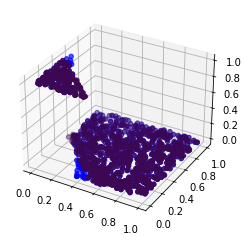

In [449]:
# Testing Split C
X_testC, X_testC_orig, y_testC = get_test_splitC(1000)

# X_testC_orig = unnormalize_data(X_testC, cache["X_testC_mean"], cache["X_testC_std"])

X_testC = torch.tensor(X_testC).float()
y_testC = torch.tensor(y_testC).view(-1, 1).float()

with torch.no_grad():
    predsC = model(X_testC[:,:2].float(), X_testC[:,2].long())
    total_acc = get_num_correct(y_testC, predsC) / len(X_testC)
    
# Comment this line out to see the non-classification predictions.
predsC = get_pred_class(predsC)

print(f"Total Accuracy on test split C: {total_acc}")

# X_testC_orig = unstandardize_data(X_testC, cache["X_testC_mean"], cache["X_testC_std"])

ax = plt.axes(projection='3d')
ax.scatter3D(X_testC_orig[:, 0], X_testC_orig[:, 1], y_testC, c="#3E0851")
ax.scatter3D(X_testC_orig[:, 0], X_testC_orig[:, 1], predsC, c='blue')